In [17]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt


In [18]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 20

In [19]:
### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [20]:
val_dataset = deepcopy(train_dataset)


In [21]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets = val_dataset.targets[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [22]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = train_dataset.targets[indexes_train]
train_dataset.data = train_dataset.data[indexes_train]

In [23]:
# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline

In [24]:
def transfer_unlabelled_to_labeled(unlabbelled_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unlabbelled_dataset.targets))])
    
    train_dataset.targets = torch.cat([train_dataset.targets, unlabbelled_dataset.targets[indexes]])
    train_dataset.data = torch.cat([train_dataset.data, unlabbelled_dataset.data[indexes]])
    unlabbelled_dataset.targets = unlabbelled_dataset.targets[~indexes]
    unlabbelled_dataset.data = unlabbelled_dataset.data[~indexes]

    return train_dataset, unlabbelled_dataset

In [25]:
def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [26]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies

In [28]:
def label_iteration(model, train_dataset, unlabelled_dataset, device, top_frac=0.01):
    # Use model to label all images in validation set
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.detach().cpu().numpy())

    predictions = torch.tensor(predictions)
    # Find top % of images with lowest top-confidence
    top_percent = int(top_frac * len(predictions))
    _, top_indices = predictions.max(-1)[0].topk(top_percent, largest=False)
    print(f"Adding {len(top_indices)} images to training set")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)
    
    return train_dataset, unlabelled_dataset

In [29]:
## Run active learning
datapoint_list = []
accuracy_list = []
for i in range(label_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration(model, train_dataset, unlabbelled_dataset, device, top_frac=0.001)

0


 11%|█         | 11/100 [00:03<00:39,  2.27it/s]

Epoch 10, Accuracy: 91.83%


 21%|██        | 21/100 [00:06<00:34,  2.30it/s]

Epoch 20, Accuracy: 91.87%


 31%|███       | 31/100 [00:09<00:30,  2.25it/s]

Epoch 30, Accuracy: 91.77%


 41%|████      | 41/100 [00:12<00:27,  2.16it/s]

Epoch 40, Accuracy: 91.78%


 51%|█████     | 51/100 [00:15<00:23,  2.08it/s]

Epoch 50, Accuracy: 91.83%


 61%|██████    | 61/100 [00:18<00:17,  2.21it/s]

Epoch 60, Accuracy: 92.03%


 71%|███████   | 71/100 [00:21<00:13,  2.22it/s]

Epoch 70, Accuracy: 92.00%


 81%|████████  | 81/100 [00:25<00:08,  2.18it/s]

Epoch 80, Accuracy: 91.90%


 91%|█████████ | 91/100 [00:28<00:04,  2.18it/s]

Epoch 90, Accuracy: 92.00%


100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Epoch 100, Accuracy: 92.10%


100%|██████████| 836/836 [00:14<00:00, 56.89it/s]


Adding 53 images to training set
1


 11%|█         | 11/100 [00:03<00:41,  2.15it/s]

Epoch 10, Accuracy: 91.03%


 21%|██        | 21/100 [00:06<00:36,  2.15it/s]

Epoch 20, Accuracy: 94.80%


 31%|███       | 31/100 [00:10<00:32,  2.15it/s]

Epoch 30, Accuracy: 94.97%


 41%|████      | 41/100 [00:13<00:27,  2.15it/s]

Epoch 40, Accuracy: 95.18%


 51%|█████     | 51/100 [00:16<00:22,  2.15it/s]

Epoch 50, Accuracy: 95.28%


 61%|██████    | 61/100 [00:19<00:18,  2.15it/s]

Epoch 60, Accuracy: 95.30%


 70%|███████   | 70/100 [00:23<00:17,  1.72it/s]

Epoch 70, Accuracy: 95.32%


 80%|████████  | 80/100 [00:26<00:11,  1.73it/s]

Epoch 80, Accuracy: 95.38%


 90%|█████████ | 90/100 [00:29<00:05,  1.74it/s]

Epoch 90, Accuracy: 95.32%


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Epoch 100, Accuracy: 95.37%


100%|██████████| 835/835 [00:14<00:00, 58.92it/s]


Adding 53 images to training set
2


 10%|█         | 10/100 [00:03<00:52,  1.70it/s]

Epoch 10, Accuracy: 94.67%


 20%|██        | 20/100 [00:06<00:46,  1.71it/s]

Epoch 20, Accuracy: 94.12%


 30%|███       | 30/100 [00:10<00:42,  1.65it/s]

Epoch 30, Accuracy: 94.52%


 40%|████      | 40/100 [00:13<00:34,  1.73it/s]

Epoch 40, Accuracy: 95.52%


 50%|█████     | 50/100 [00:17<00:28,  1.73it/s]

Epoch 50, Accuracy: 95.53%


 60%|██████    | 60/100 [00:20<00:23,  1.69it/s]

Epoch 60, Accuracy: 95.72%


 70%|███████   | 70/100 [00:23<00:17,  1.71it/s]

Epoch 70, Accuracy: 95.90%


 80%|████████  | 80/100 [00:27<00:11,  1.71it/s]

Epoch 80, Accuracy: 95.85%


 90%|█████████ | 90/100 [00:30<00:05,  1.72it/s]

Epoch 90, Accuracy: 95.78%


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


Epoch 100, Accuracy: 95.85%


100%|██████████| 834/834 [00:14<00:00, 58.44it/s]


Adding 53 images to training set
3


 10%|█         | 10/100 [00:03<00:52,  1.71it/s]

Epoch 10, Accuracy: 95.08%


 20%|██        | 20/100 [00:06<00:46,  1.72it/s]

Epoch 20, Accuracy: 96.07%


 30%|███       | 30/100 [00:10<00:40,  1.71it/s]

Epoch 30, Accuracy: 96.17%


 40%|████      | 40/100 [00:13<00:35,  1.71it/s]

Epoch 40, Accuracy: 96.23%


 50%|█████     | 50/100 [00:17<00:29,  1.72it/s]

Epoch 50, Accuracy: 96.33%


 60%|██████    | 60/100 [00:20<00:23,  1.68it/s]

Epoch 60, Accuracy: 96.28%


 70%|███████   | 70/100 [00:23<00:17,  1.70it/s]

Epoch 70, Accuracy: 96.48%


 80%|████████  | 80/100 [00:27<00:11,  1.70it/s]

Epoch 80, Accuracy: 96.47%


 90%|█████████ | 90/100 [00:30<00:05,  1.71it/s]

Epoch 90, Accuracy: 96.47%


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


Epoch 100, Accuracy: 96.47%


100%|██████████| 833/833 [00:14<00:00, 57.74it/s]


Adding 53 images to training set
4


 10%|█         | 10/100 [00:03<00:54,  1.66it/s]

Epoch 10, Accuracy: 92.82%


 20%|██        | 20/100 [00:07<00:48,  1.65it/s]

Epoch 20, Accuracy: 96.28%


 30%|███       | 30/100 [00:10<00:42,  1.66it/s]

Epoch 30, Accuracy: 96.62%


 40%|████      | 40/100 [00:14<00:36,  1.67it/s]

Epoch 40, Accuracy: 96.70%


 50%|█████     | 50/100 [00:18<00:30,  1.66it/s]

Epoch 50, Accuracy: 96.85%


 60%|██████    | 60/100 [00:21<00:24,  1.66it/s]

Epoch 60, Accuracy: 96.72%


 70%|███████   | 70/100 [00:25<00:18,  1.66it/s]

Epoch 70, Accuracy: 96.73%


 80%|████████  | 80/100 [00:28<00:12,  1.65it/s]

Epoch 80, Accuracy: 96.75%


 90%|█████████ | 90/100 [00:32<00:06,  1.65it/s]

Epoch 90, Accuracy: 96.83%


100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


Epoch 100, Accuracy: 96.80%


100%|██████████| 832/832 [00:14<00:00, 56.81it/s]


Adding 53 images to training set
5


 10%|█         | 10/100 [00:03<00:56,  1.59it/s]

Epoch 10, Accuracy: 96.32%


 20%|██        | 20/100 [00:07<00:50,  1.59it/s]

Epoch 20, Accuracy: 96.82%


 30%|███       | 30/100 [00:11<00:44,  1.59it/s]

Epoch 30, Accuracy: 97.07%


 40%|████      | 40/100 [00:15<00:39,  1.54it/s]

Epoch 40, Accuracy: 97.15%


 50%|█████     | 50/100 [00:20<00:38,  1.31it/s]

Epoch 50, Accuracy: 97.20%


 60%|██████    | 60/100 [00:24<00:26,  1.49it/s]

Epoch 60, Accuracy: 97.27%


 70%|███████   | 70/100 [00:28<00:20,  1.46it/s]

Epoch 70, Accuracy: 97.28%


 80%|████████  | 80/100 [00:32<00:14,  1.40it/s]

Epoch 80, Accuracy: 97.18%


 90%|█████████ | 90/100 [00:36<00:06,  1.57it/s]

Epoch 90, Accuracy: 97.27%


100%|██████████| 100/100 [00:40<00:00,  2.46it/s]


Epoch 100, Accuracy: 97.28%


100%|██████████| 832/832 [00:15<00:00, 54.79it/s]


Adding 53 images to training set
6


 10%|█         | 10/100 [00:04<01:03,  1.42it/s]

Epoch 10, Accuracy: 95.00%


 20%|██        | 20/100 [00:08<00:55,  1.45it/s]

Epoch 20, Accuracy: 96.22%


 30%|███       | 30/100 [00:12<00:48,  1.44it/s]

Epoch 30, Accuracy: 97.08%


 40%|████      | 40/100 [00:17<00:40,  1.49it/s]

Epoch 40, Accuracy: 97.13%


 50%|█████     | 50/100 [00:21<00:33,  1.48it/s]

Epoch 50, Accuracy: 97.20%


 60%|██████    | 60/100 [00:25<00:27,  1.46it/s]

Epoch 60, Accuracy: 97.10%


 70%|███████   | 70/100 [00:29<00:20,  1.50it/s]

Epoch 70, Accuracy: 97.12%


 80%|████████  | 80/100 [00:33<00:13,  1.52it/s]

Epoch 80, Accuracy: 97.08%


 90%|█████████ | 90/100 [00:37<00:06,  1.52it/s]

Epoch 90, Accuracy: 97.18%


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Epoch 100, Accuracy: 97.27%


100%|██████████| 831/831 [00:14<00:00, 56.60it/s]


Adding 53 images to training set
7


 10%|█         | 10/100 [00:04<01:01,  1.46it/s]

Epoch 10, Accuracy: 94.52%


 20%|██        | 20/100 [00:08<00:56,  1.42it/s]

Epoch 20, Accuracy: 96.65%


 30%|███       | 30/100 [00:13<00:47,  1.49it/s]

Epoch 30, Accuracy: 97.03%


 40%|████      | 40/100 [00:17<00:40,  1.47it/s]

Epoch 40, Accuracy: 97.15%


 50%|█████     | 50/100 [00:21<00:34,  1.45it/s]

Epoch 50, Accuracy: 97.12%


 60%|██████    | 60/100 [00:26<00:27,  1.47it/s]

Epoch 60, Accuracy: 97.07%


 70%|███████   | 70/100 [00:30<00:20,  1.49it/s]

Epoch 70, Accuracy: 97.13%


 80%|████████  | 80/100 [00:34<00:13,  1.46it/s]

Epoch 80, Accuracy: 97.17%


 90%|█████████ | 90/100 [00:39<00:06,  1.49it/s]

Epoch 90, Accuracy: 97.13%


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Epoch 100, Accuracy: 97.10%


100%|██████████| 830/830 [00:14<00:00, 57.29it/s]


Adding 53 images to training set
8


 10%|█         | 10/100 [00:04<01:02,  1.43it/s]

Epoch 10, Accuracy: 96.55%


 20%|██        | 20/100 [00:09<00:56,  1.42it/s]

Epoch 20, Accuracy: 97.23%


 30%|███       | 30/100 [00:13<00:48,  1.44it/s]

Epoch 30, Accuracy: 97.18%


 40%|████      | 40/100 [00:18<00:42,  1.42it/s]

Epoch 40, Accuracy: 97.33%


 50%|█████     | 50/100 [00:22<00:34,  1.44it/s]

Epoch 50, Accuracy: 97.37%


 60%|██████    | 60/100 [00:27<00:27,  1.45it/s]

Epoch 60, Accuracy: 97.37%


 70%|███████   | 70/100 [00:31<00:20,  1.44it/s]

Epoch 70, Accuracy: 97.48%


 80%|████████  | 80/100 [00:36<00:13,  1.44it/s]

Epoch 80, Accuracy: 97.55%


 90%|█████████ | 90/100 [00:40<00:07,  1.40it/s]

Epoch 90, Accuracy: 97.52%


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Epoch 100, Accuracy: 97.42%


100%|██████████| 829/829 [00:14<00:00, 56.69it/s]


Adding 53 images to training set
9


 10%|█         | 10/100 [00:04<01:03,  1.41it/s]

Epoch 10, Accuracy: 96.68%


 20%|██        | 20/100 [00:09<00:55,  1.44it/s]

Epoch 20, Accuracy: 95.83%


 30%|███       | 30/100 [00:13<00:48,  1.44it/s]

Epoch 30, Accuracy: 95.18%


 40%|████      | 40/100 [00:18<00:41,  1.44it/s]

Epoch 40, Accuracy: 96.78%


 50%|█████     | 50/100 [00:22<00:34,  1.43it/s]

Epoch 50, Accuracy: 97.68%


 60%|██████    | 60/100 [00:27<00:29,  1.36it/s]

Epoch 60, Accuracy: 97.37%


 70%|███████   | 70/100 [00:32<00:21,  1.42it/s]

Epoch 70, Accuracy: 96.57%


 80%|████████  | 80/100 [00:36<00:14,  1.41it/s]

Epoch 80, Accuracy: 95.87%


 90%|█████████ | 90/100 [00:41<00:07,  1.41it/s]

Epoch 90, Accuracy: 92.83%


100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


Epoch 100, Accuracy: 97.57%


100%|██████████| 828/828 [00:14<00:00, 56.39it/s]


Adding 52 images to training set
10


 10%|█         | 10/100 [00:04<01:05,  1.37it/s]

Epoch 10, Accuracy: 94.93%


 20%|██        | 20/100 [00:09<00:57,  1.39it/s]

Epoch 20, Accuracy: 96.78%


 30%|███       | 30/100 [00:14<00:49,  1.40it/s]

Epoch 30, Accuracy: 97.28%


 40%|████      | 40/100 [00:19<00:42,  1.40it/s]

Epoch 40, Accuracy: 97.37%


 50%|█████     | 50/100 [00:23<00:35,  1.40it/s]

Epoch 50, Accuracy: 97.37%


 60%|██████    | 60/100 [00:28<00:28,  1.38it/s]

Epoch 60, Accuracy: 97.40%


 70%|███████   | 70/100 [00:33<00:21,  1.38it/s]

Epoch 70, Accuracy: 97.50%


 80%|████████  | 80/100 [00:38<00:14,  1.37it/s]

Epoch 80, Accuracy: 97.55%


 90%|█████████ | 90/100 [00:43<00:07,  1.34it/s]

Epoch 90, Accuracy: 97.58%


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Epoch 100, Accuracy: 97.52%


100%|██████████| 828/828 [00:14<00:00, 56.53it/s]


Adding 52 images to training set
11


 10%|█         | 10/100 [00:05<01:08,  1.32it/s]

Epoch 10, Accuracy: 96.47%


 20%|██        | 20/100 [00:10<01:01,  1.31it/s]

Epoch 20, Accuracy: 96.80%


 30%|███       | 30/100 [00:15<00:53,  1.30it/s]

Epoch 30, Accuracy: 97.80%


 40%|████      | 40/100 [00:20<00:44,  1.34it/s]

Epoch 40, Accuracy: 97.78%


 50%|█████     | 50/100 [00:25<00:37,  1.34it/s]

Epoch 50, Accuracy: 97.85%


 60%|██████    | 60/100 [00:30<00:29,  1.35it/s]

Epoch 60, Accuracy: 97.87%


 70%|███████   | 70/100 [00:35<00:22,  1.33it/s]

Epoch 70, Accuracy: 97.92%


 80%|████████  | 80/100 [00:40<00:15,  1.30it/s]

Epoch 80, Accuracy: 97.92%


 90%|█████████ | 90/100 [00:45<00:07,  1.34it/s]

Epoch 90, Accuracy: 97.92%


100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Epoch 100, Accuracy: 97.90%


100%|██████████| 827/827 [00:14<00:00, 57.32it/s]


Adding 52 images to training set
12


 10%|█         | 10/100 [00:05<01:09,  1.30it/s]

Epoch 10, Accuracy: 94.83%


 20%|██        | 20/100 [00:10<01:01,  1.31it/s]

Epoch 20, Accuracy: 96.73%


 30%|███       | 30/100 [00:15<00:53,  1.31it/s]

Epoch 30, Accuracy: 95.43%


 40%|████      | 40/100 [00:20<00:45,  1.32it/s]

Epoch 40, Accuracy: 96.03%


 50%|█████     | 50/100 [00:25<00:37,  1.32it/s]

Epoch 50, Accuracy: 97.48%


 60%|██████    | 60/100 [00:31<00:30,  1.33it/s]

Epoch 60, Accuracy: 97.80%


 70%|███████   | 70/100 [00:36<00:22,  1.33it/s]

Epoch 70, Accuracy: 97.78%


 80%|████████  | 80/100 [00:41<00:15,  1.32it/s]

Epoch 80, Accuracy: 97.95%


 90%|█████████ | 90/100 [00:46<00:07,  1.33it/s]

Epoch 90, Accuracy: 97.88%


100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Epoch 100, Accuracy: 97.98%


100%|██████████| 826/826 [00:14<00:00, 57.07it/s]


Adding 52 images to training set
13


 10%|█         | 10/100 [00:05<01:12,  1.24it/s]

Epoch 10, Accuracy: 94.13%


 20%|██        | 20/100 [00:11<01:05,  1.22it/s]

Epoch 20, Accuracy: 97.72%


 30%|███       | 30/100 [00:16<00:55,  1.26it/s]

Epoch 30, Accuracy: 95.67%


 40%|████      | 40/100 [00:21<00:47,  1.25it/s]

Epoch 40, Accuracy: 96.63%


 50%|█████     | 50/100 [00:27<00:39,  1.28it/s]

Epoch 50, Accuracy: 97.45%


 60%|██████    | 60/100 [00:33<00:35,  1.14it/s]

Epoch 60, Accuracy: 97.15%


 70%|███████   | 70/100 [00:39<00:23,  1.25it/s]

Epoch 70, Accuracy: 97.60%


 80%|████████  | 80/100 [00:44<00:17,  1.16it/s]

Epoch 80, Accuracy: 97.82%


 90%|█████████ | 90/100 [00:50<00:08,  1.12it/s]

Epoch 90, Accuracy: 97.90%


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


Epoch 100, Accuracy: 97.83%


100%|██████████| 825/825 [00:13<00:00, 59.46it/s]


Adding 52 images to training set
14


 10%|█         | 10/100 [00:05<01:12,  1.24it/s]

Epoch 10, Accuracy: 95.42%


 20%|██        | 20/100 [00:11<01:04,  1.25it/s]

Epoch 20, Accuracy: 95.02%


 30%|███       | 30/100 [00:16<00:55,  1.25it/s]

Epoch 30, Accuracy: 96.47%


 40%|████      | 40/100 [00:22<00:48,  1.23it/s]

Epoch 40, Accuracy: 97.93%


 50%|█████     | 50/100 [00:28<00:40,  1.22it/s]

Epoch 50, Accuracy: 98.02%


 60%|██████    | 60/100 [00:33<00:32,  1.24it/s]

Epoch 60, Accuracy: 98.02%


 70%|███████   | 70/100 [00:39<00:23,  1.28it/s]

Epoch 70, Accuracy: 98.03%


 80%|████████  | 80/100 [00:44<00:15,  1.28it/s]

Epoch 80, Accuracy: 98.03%


 90%|█████████ | 90/100 [00:49<00:07,  1.28it/s]

Epoch 90, Accuracy: 98.05%


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Epoch 100, Accuracy: 98.13%


100%|██████████| 824/824 [00:14<00:00, 57.62it/s]


Adding 52 images to training set
15


 10%|█         | 10/100 [00:05<01:14,  1.21it/s]

Epoch 10, Accuracy: 95.37%


 20%|██        | 20/100 [00:12<01:10,  1.14it/s]

Epoch 20, Accuracy: 96.90%


 30%|███       | 30/100 [00:18<01:01,  1.15it/s]

Epoch 30, Accuracy: 94.32%


 40%|████      | 40/100 [00:23<00:50,  1.20it/s]

Epoch 40, Accuracy: 97.85%


 50%|█████     | 50/100 [00:29<00:40,  1.23it/s]

Epoch 50, Accuracy: 97.90%


 60%|██████    | 60/100 [00:35<00:32,  1.25it/s]

Epoch 60, Accuracy: 95.68%


 70%|███████   | 70/100 [00:40<00:23,  1.25it/s]

Epoch 70, Accuracy: 95.37%


 80%|████████  | 80/100 [00:46<00:15,  1.25it/s]

Epoch 80, Accuracy: 97.80%


 90%|█████████ | 90/100 [00:51<00:07,  1.25it/s]

Epoch 90, Accuracy: 98.18%


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Epoch 100, Accuracy: 98.15%


100%|██████████| 823/823 [00:14<00:00, 58.70it/s]


Adding 52 images to training set
16


 10%|█         | 10/100 [00:05<01:14,  1.21it/s]

Epoch 10, Accuracy: 93.80%


 20%|██        | 20/100 [00:11<01:06,  1.21it/s]

Epoch 20, Accuracy: 97.95%


 30%|███       | 30/100 [00:17<00:57,  1.21it/s]

Epoch 30, Accuracy: 97.53%


 40%|████      | 40/100 [00:23<00:49,  1.22it/s]

Epoch 40, Accuracy: 95.52%


 50%|█████     | 50/100 [00:29<00:41,  1.22it/s]

Epoch 50, Accuracy: 97.90%


 60%|██████    | 60/100 [00:35<00:33,  1.18it/s]

Epoch 60, Accuracy: 97.98%


 70%|███████   | 70/100 [00:40<00:24,  1.21it/s]

Epoch 70, Accuracy: 98.08%


 80%|████████  | 80/100 [00:46<00:16,  1.21it/s]

Epoch 80, Accuracy: 98.12%


 90%|█████████ | 90/100 [00:52<00:08,  1.22it/s]

Epoch 90, Accuracy: 98.03%


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Epoch 100, Accuracy: 98.07%


100%|██████████| 823/823 [00:13<00:00, 58.86it/s]


Adding 52 images to training set
17


 10%|█         | 10/100 [00:06<01:16,  1.18it/s]

Epoch 10, Accuracy: 95.63%


 20%|██        | 20/100 [00:12<01:07,  1.19it/s]

Epoch 20, Accuracy: 96.12%


 30%|███       | 30/100 [00:18<00:59,  1.18it/s]

Epoch 30, Accuracy: 97.63%


 40%|████      | 40/100 [00:24<00:51,  1.17it/s]

Epoch 40, Accuracy: 95.45%


 50%|█████     | 50/100 [00:30<00:42,  1.17it/s]

Epoch 50, Accuracy: 97.45%


 60%|██████    | 60/100 [00:36<00:33,  1.19it/s]

Epoch 60, Accuracy: 97.58%


 70%|███████   | 70/100 [00:42<00:25,  1.19it/s]

Epoch 70, Accuracy: 98.30%


 80%|████████  | 80/100 [00:48<00:16,  1.19it/s]

Epoch 80, Accuracy: 98.25%


 90%|█████████ | 90/100 [00:54<00:08,  1.13it/s]

Epoch 90, Accuracy: 98.30%


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


Epoch 100, Accuracy: 98.18%


100%|██████████| 822/822 [00:14<00:00, 58.16it/s]


Adding 52 images to training set
18


 10%|█         | 10/100 [00:06<01:18,  1.15it/s]

Epoch 10, Accuracy: 93.75%


 20%|██        | 20/100 [00:12<01:09,  1.14it/s]

Epoch 20, Accuracy: 97.25%


 30%|███       | 30/100 [00:18<01:01,  1.15it/s]

Epoch 30, Accuracy: 98.22%


 40%|████      | 40/100 [00:25<00:53,  1.12it/s]

Epoch 40, Accuracy: 98.07%


 50%|█████     | 50/100 [00:31<00:45,  1.11it/s]

Epoch 50, Accuracy: 98.25%


 60%|██████    | 60/100 [00:38<00:35,  1.13it/s]

Epoch 60, Accuracy: 98.38%


 70%|███████   | 70/100 [00:44<00:26,  1.15it/s]

Epoch 70, Accuracy: 98.27%


 80%|████████  | 80/100 [00:50<00:17,  1.14it/s]

Epoch 80, Accuracy: 98.35%


 90%|█████████ | 90/100 [00:57<00:08,  1.16it/s]

Epoch 90, Accuracy: 98.33%


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Epoch 100, Accuracy: 98.32%


100%|██████████| 821/821 [00:14<00:00, 57.71it/s]


Adding 52 images to training set
19


 10%|█         | 10/100 [00:06<01:20,  1.11it/s]

Epoch 10, Accuracy: 97.52%


 20%|██        | 20/100 [00:13<01:13,  1.09it/s]

Epoch 20, Accuracy: 98.38%


 30%|███       | 30/100 [00:19<01:02,  1.11it/s]

Epoch 30, Accuracy: 98.27%


 40%|████      | 40/100 [00:26<00:54,  1.11it/s]

Epoch 40, Accuracy: 95.00%


 50%|█████     | 50/100 [00:33<00:46,  1.08it/s]

Epoch 50, Accuracy: 97.72%


 60%|██████    | 60/100 [00:39<00:35,  1.12it/s]

Epoch 60, Accuracy: 98.12%


 70%|███████   | 70/100 [00:46<00:26,  1.11it/s]

Epoch 70, Accuracy: 98.23%


 80%|████████  | 80/100 [00:52<00:17,  1.13it/s]

Epoch 80, Accuracy: 98.20%


 90%|█████████ | 90/100 [00:59<00:08,  1.12it/s]

Epoch 90, Accuracy: 98.18%


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]

Epoch 100, Accuracy: 98.22%


In [30]:
# Add baseline accuracy (no active learning)
n_datapoints = len(train_dataset) - len(start_train_dataset)
model.load_state_dict(model_parameters)
# We reuse the initial training set to reduce run to run variance
train_dataset.data = torch.cat([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = torch.cat([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

In [31]:
# Train model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)

 10%|█         | 10/100 [00:06<01:21,  1.11it/s]

Epoch 10, Accuracy: 95.05%


 20%|██        | 20/100 [00:13<01:11,  1.11it/s]

Epoch 20, Accuracy: 96.72%


 30%|███       | 30/100 [00:19<01:02,  1.12it/s]

Epoch 30, Accuracy: 93.88%


 40%|████      | 40/100 [00:26<00:56,  1.07it/s]

Epoch 40, Accuracy: 95.63%


 50%|█████     | 50/100 [00:32<00:45,  1.11it/s]

Epoch 50, Accuracy: 96.47%


 60%|██████    | 60/100 [00:39<00:35,  1.12it/s]

Epoch 60, Accuracy: 96.58%


 70%|███████   | 70/100 [00:45<00:27,  1.11it/s]

Epoch 70, Accuracy: 96.77%


 80%|████████  | 80/100 [00:52<00:18,  1.11it/s]

Epoch 80, Accuracy: 96.82%


 90%|█████████ | 90/100 [00:59<00:09,  1.09it/s]

Epoch 90, Accuracy: 96.95%


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]

Epoch 100, Accuracy: 96.95%


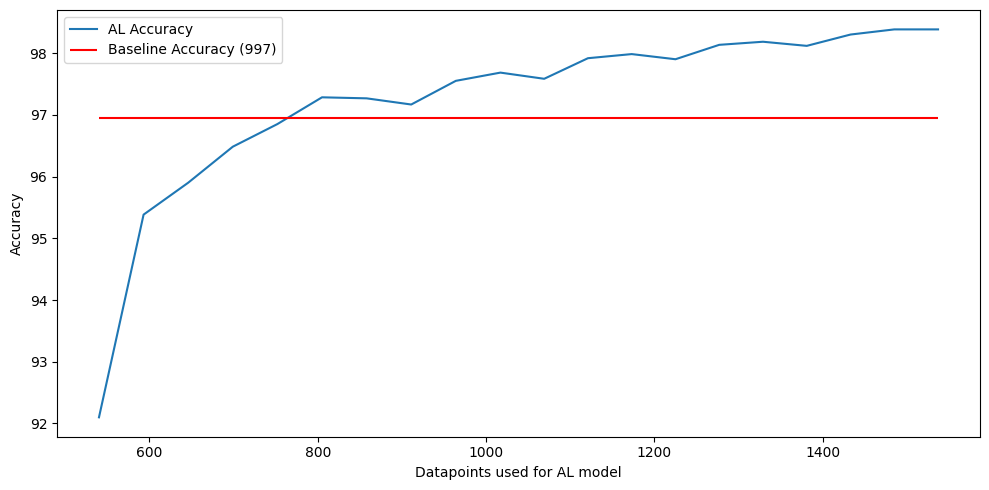

In [36]:
# Plot the accuracy
datapoints = np.array(datapoint_list)
accuracies = np.array(accuracy_list).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label=f'Baseline Accuracy ({n_datapoints})', color='red')
plt.xlabel('Datapoints used for AL model')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/accuracy.png')
plt.show()

In [35]:
n_datapoints

997